In [1]:
from seal import *
import time
import torch
import numpy as np


parms = EncryptionParameters(scheme_type.bfv)
poly_modulus_degree = 8192
parms.set_poly_modulus_degree(poly_modulus_degree)
parms.set_coeff_modulus(CoeffModulus.BFVDefault(2048))
parms.set_plain_modulus(2**19)
context = SEALContext(parms)



In [2]:
def serialize(tensor, unit):
    flattened = tensor.reshape(-1)
    serialized = [flattened[i*unit:(i+1)*unit] for i in range(1+int(flattened.shape[0]/unit))]
    return serialized, tensor.shape

def scale_and_round(vector, scale_factor, shift_amount):
    a_vector = vector+shift_amount
    a_vector = a_vector*scale_factor
    return a_vector.int()

def recon(vector_list, shape, scale_factor):
    vector = torch.concat(vector_list,axis=-1)
    return (vector.reshape(shape))/scale_factor


In [3]:
def numpy_to_string(np_array):
    x = np.zeros([poly_modulus_degree])
    # x[:len(np_array)].shape
    x[:len(np_array)] = np_array
    res = ""
    for i, v in enumerate(x[::-1]):
        i = poly_modulus_degree-i-1
        if i != 0 and v > 0:
            res += f"{hex(int(v))}"[2:]+f"x^{i} + "
        elif i==0:
            res += f"{hex(int(v))}"[2:]
    return res
def string_to_numpy(hex_poly):
    elem = hex_poly.split(" + ")
    if('x' not in elem[-1]):
        elem[-1] += "x^0"
    values = [int("0x"+e.split("x")[0],16) for e in elem]
    keys = [int(e.split("x^")[1]) for e in elem]
    results = torch.zeros([poly_modulus_degree],dtype=int)
    for k,v in zip(keys, values):
        results[k] = v
    return results

In [4]:
from collections import defaultdict
class PythonParty(Party):
    def __init__(self,model,*args,**kwargs):
        super().__init__(*args, **kwargs)
        self.model = model
    def __call__(self,x):
        return self.model(x)
    
    def get_grad(self):
        """return a dictionary that having model gradient information"""
        res = defaultdict(None)
        for i,layer in enumerate(self.model.layers()):
            res[f"{i}_weight"] = layer.weight.grad
            res[f"{i}_bias"] = layer.bias.grad
        return res
    
    def update_weight(self, grad, lr=0.01):
        with torch.no_grad():
            for k, v in grad.items():
                if v is None: continue
                layer_number, layer_type = k.split("_")
                layer_data = self.model.__getattr__(f"layer{int(layer_number)+1}").__getattr__(layer_type)
                layer_data -= lr*v

    
    def encrypt_tensor(self, tensor, scale, shamt):
        ser_list, ori_shape = serialize(tensor, poly_modulus_degree)
        if(ser_list[-1].shape[0]==0): ser_list = ser_list[:-1]
        ser_list = [scale_and_round(v, scale, shamt) for v in ser_list]
        ser_list = [Plaintext(numpy_to_string(v)) for v in ser_list]
        print(ser_list)
        ser_list_encrypted = [self.encrypt(st) for st in ser_list]
        return ser_list_encrypted, ori_shape
    
    

In [5]:
class PythonProtocol(Protocol):
    def __init__(self, evaluator, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.evaluator = evaluator
    def secure_add(self, tensor_a, tensor_b, party_a, party_b, scale=100, shamt=0):
        ctx_a_list, shape_a = party_a.encrypt_tensor(tensor_a, scale, shamt)
        ctx_b_list, shape_b = party_b.encrypt_tensor(tensor_b, scale, shamt)
        res = []
        for ctx_a, ctx_b in zip(ctx_a_list, ctx_b_list):
            ctx_res = self.evaluator.add(ctx_a, ctx_b)
            dec = proto.decrypt(ctx_res)
            res.append(string_to_numpy(dec.to_string()))
        res = recon(res, shape_a, scale)-2*shamt
        return res

In [6]:
from torch import nn
class Classifier(nn.Module):
    def __init__(self, layer1=128, layer2=256, output=10):
        super().__init__()
        self.layer1 = nn.Linear(784, layer1)
        self.layer2 = nn.Linear(layer1, layer2)
        self.layer3 = nn.Linear(layer2, output)
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=1.0)
            if module.bias is not None:
                module.bias.data.zero_()
    def layers(self):
        return [self.layer1, self.layer2, self.layer3]
    def forward(self,x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        x = nn.ReLU()(x)
        x = self.layer3(x)
        x = nn.functional.softmax(x)
        return x


In [8]:
n = 200
t = 20
val = Evaluator(context)
proto = PythonProtocol(val,context,t)

parties = []
for i in range(n):
    p = PythonParty(Classifier(),context)
    parties.append(p)
    p.register(proto)
for i in range(n):
    proto.calculate_share(i+1)
proto.generate_pk()
parties[1].update_pk()
x = torch.rand([2,8192])
y = 0.5-x
t = time.time()
z = proto.secure_add(x,y,parties[2], parties[5], scale=100000, shamt=1)
print("Add time: ", time.time()-t)
print(z)



GATHERING
[<seal.Plaintext object at 0x7fb6b74eb8b0>, <seal.Plaintext object at 0x7fb6b2cdba70>]
[<seal.Plaintext object at 0x7fb6b74eb8b0>, <seal.Plaintext object at 0x7fb6b2cdba70>]
Add time:  0.1527876853942871
tensor([[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]])


In [8]:
import torch
x = torch.rand([1,784])
cr = nn.CrossEntropyLoss()
y = torch.ones([1],dtype=torch.uint8)
z = parties[0](x)
z_ = parties[1](x)
loss = cr(z, y)
l2 = cr(z_,y)
loss.backward()
l2.backward()
# model(x).shape

NameError: name 'parties' is not defined

In [ ]:
first = parties[0].get_grad()["1_weight"]
second = parties[1].get_grad()["1_weight"]
t = time.time()
print(proto.secure_add(first, second, parties[0],parties[1], scale=100000,shamt=1).max())
print(time.time()-t)

In [ ]:
(first+second).max()

In [9]:
model = Classifier()
m2 = Classifier()

In [10]:
def serialize(tensor, unit):
    flattened = tensor.reshape(-1)
    serialized = [flattened[i*unit:(i+1)*unit] for i in range(1+int(flattened.shape[0]/unit))]
    return serialized, tensor.shape

def scale_and_round(vector, scale_factor, shift_amount):
    a_vector = vector+shift_amount
    a_vector = a_vector*scale_factor
    return a_vector.int()

def recon(vector_list, shape, scale_factor):
    vector = torch.concat(vector_list,axis=-1)
    return (vector.reshape(shape))/scale_factor


In [11]:
import struct
import numpy as np

def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)

In [12]:
data = read_idx("MNIST/raw/train-images-idx3-ubyte")
label = read_idx("MNIST/raw/train-labels-idx1-ubyte")

/tmp/ipykernel_60057/58950648.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)


In [13]:
label.shape

(60000,)

In [14]:
ls MNIST/raw

t10k-images-idx3-ubyte     train-images-idx3-ubyte
t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte.gz
t10k-labels-idx1-ubyte     train-labels-idx1-ubyte
t10k-labels-idx1-ubyte.gz  train-labels-idx1-ubyte.gz


[5 0 4 1]


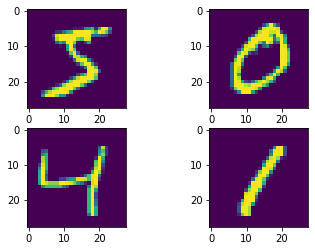

In [15]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 2)
for i in range(4):
    axs[i//2,i%2].imshow(data[i,:,:])
print(label[:4])

In [16]:
import random
import copy
global_model = Classifier()
n = 10
t = 2
val = Evaluator(context)
proto = PythonProtocol(val,context,t)

parties = []
for i in range(n):
    p = PythonParty(copy.deepcopy(global_model),context)
    parties.append(p)
    p.register(proto)
for i in range(n):
    proto.calculate_share(i+1)
    
def train(protocol, parties, dataset, labels, n_rounds=1, party_per_round=2):
    for ruond in range(n_rounds):
        chosen_ps_id = random.sample(range(len(parties)), party_per_round)
        chosen_ps = [(i,parties[i]) for i in chosen_ps_id]
        grad_infos = []
        total = defaultdict(None)
        
        for c, (i, p) in enumerate(chosen_ps):
            datas = dataset[i]
            labls = labels[i]
            pred = p(datas)
            local_loss = cr(pred, labls)
            local_loss.backward()
            #             grad_infos.append([i,p.get_grad()])
            infos = p.get_grad()
            if c == 0:
                for k,v in infos.items():
                    total[k] = v
            else:
                for k,v in infos.items():
                    total[k] = proto.secure_add(v,total[k],parties[0],parties[i],scale=10000,shamt=10)
                    print("1")
        for k,v in total.items():
            if v is not None:
                v /= party_per_round
        print("Here here")
        for p in parties:
            p.update_weight(total)
            
                    
                

In [17]:
model.__getattr__("layer1")

Linear(in_features=784, out_features=128, bias=True)

In [18]:
dats = [None]*len(parties)
lbls = [None]*len(parties)
for i, p in enumerate(parties):
    dats[i] = torch.Tensor(data[i::len(parties),:,:])
    lbls[i] = torch.Tensor(label[i::len(parties)]).long()

In [19]:
# train(proto, parties, dats, lbls)

In [21]:
n_rounds = 5
party_per_round = 4
for ruond in range(n_rounds):
    chosen_ps_id = random.sample(range(len(parties)), party_per_round)
    chosen_ps = [(i,parties[i]) for i in chosen_ps_id]
    grad_infos = []
    total = defaultdict(None)
    print("haha")
    for c, (i, p) in enumerate(chosen_ps):
        datas = dats[i]
        labls = lbls[i]
        pred = p(datas)
        local_loss = cr(pred, labls)
        local_loss.backward()
#         #             grad_infos.append([i,p.get_grad()])
        infos = p.get_grad()
        if c == 0:
            for k,v in infos.items():
                total[k] = v
        else:
            for k,v in infos.items():
                if v is None: continue
                total[k] += v
#                 print(v.shape)
#                 total[k] = proto.secure_add(v,total[k],parties[0],parties[i],scale=10000,shamt=10)
#                 print("1")
    for k,v in total.items():
        if v is not None:
            v /= party_per_round
    print("Here here")
    for p in parties:
        p.update_weight(total)

haha
Here here
haha
Here here
haha
Here here


/tmp/ipykernel_60057/1948082911.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = nn.functional.softmax(x)


In [38]:
parties[4](torch.Tensor(test_data[1:2]))

/tmp/ipykernel_60057/1948082911.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = nn.functional.softmax(x)


tensor([[9.9496e-06, 1.6769e-07, 9.9385e-01, 1.3642e-06, 3.8790e-11, 1.1689e-06,
         6.1235e-03, 1.0313e-09, 1.8185e-05, 8.0572e-13]],
       grad_fn=<SoftmaxBackward0>)

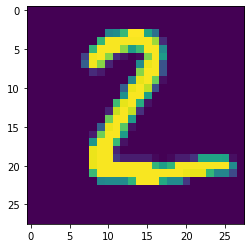

In [34]:
plt.imshow(test_data[1])

In [33]:
test_data = read_idx("MNIST/raw/t10k-images-idx3-ubyte")

/tmp/ipykernel_60057/58950648.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)
